<a href="https://colab.research.google.com/github/seokhee516/kaggle-practice/blob/main/study/Getting_Started_with_a_Movie_Recommendation_System.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

The Movies Dataset GCS_DS_PATH = "gs://kds-b8b70c75a3f12c101a2fe788fa7e9e1c8457d0d020f8e60910667880"

In [ ]:
!pip install gcsfs
# TMDB 5000 Movie Dataset
GCS_DS_PATH = "gs://kds-d176ad908f5c997f0b76bab23944366b9b5efb61105eaf194f12d1b7"

# The Age of Recommender Systems(추천 시스템의 시대)

Demographic Filtering(인구통계학적 필터링) - 영화 인기도 및/또는 장르를 기반으로 모든 사용자에게 일반화된 추천을 제공합니다. 시스템은 유사한 인구 통계학적 특징을 가진 사용자에게 동일한 영화를 추천합니다. 사용자마다 다르기 때문에 이 접근 방식은 너무 단순하다고 간주됩니다. 이 시스템의 기본 아이디어는 더 인기 있고 비평가들의 찬사를 받은 영화가 일반 관객에게 더 좋아질 확률이 더 높다는 것입니다.

Content Based Filtering(콘텐츠 기반 필터링) - 특정 항목을 기반으로 유사한 항목을 제안합니다. 이 시스템은 영화의 장르, 감독, 설명, 배우 등과 같은 항목 메타데이터를 사용하여 이러한 권장 사항을 만듭니다. 이러한 추천 시스템의 이면에 있는 일반적인 아이디어는 사람이 특정 항목을 좋아하면 그와 유사한 항목도 좋아한다는 것입니다.

Collaborative Filtering(협업 필터링) - 이 시스템은 비슷한 관심사를 가진 사람들을 매칭하고 이 매칭을 기반으로 추천을 제공합니다. 협업 필터에는 콘텐츠 기반 필터와 같은 항목 메타데이터가 필요하지 않습니다.

In [4]:
import pandas as pd 
import numpy as np 

df1=pd.read_csv(GCS_DS_PATH+'/tmdb_5000_credits.csv')
df2=pd.read_csv(GCS_DS_PATH+'/tmdb_5000_movies.csv')

### df1 credits
- movie_id - A unique identifier for each movie.
- cast - The name of lead and supporting actors.
- crew - The name of Director, Editor, Composer, Writer etc.

### df2 movies
- budget - The budget in which the movie was made.
- genre - The genre of the movie, Action, Comedy ,Thriller etc.
- homepage - A link to the homepage of the movie.
- id - This is infact the movie_id as in the first dataset.
- keywords - The keywords or tags related to the movie.
- original_language - The language in which the movie was made.
- original_title - The title of the movie before translation or adaptation.
- overview - A brief description of the movie.
- popularity - A numeric quantity specifying the movie popularity.
- production_companies - The production house of the movie.
- production_countries - The country in which it was produced.
- release_date - The date on which it was released.
- revenue - The worldwide revenue generated by the movie.
- runtime - The running time of the movie in minutes.
- status - "Released" or "Rumored".
- tagline - Movie's tagline.
- title - Title of the movie.
- vote_average - average ratings the movie recieved.
- vote_count - the count of votes recieved.

In [6]:
df1.columns = ['id','tittle','cast','crew']
df2= df2.merge(df1,on='id')

In [7]:
df2.head(5)

,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,tittle,cast,crew
0,237000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.avatarmovie.com/,19995,"[{""id"": 1463, ""name"": ""culture clash""}, {""id"":...",en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,"[{""name"": ""Ingenious Film Partners"", ""id"": 289...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2009-12-10,2787965087,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Avatar,"[{""cast_id"": 242, ""character"": ""Jake Sully"", ""...","[{""credit_id"": ""52fe48009251416c750aca23"", ""de..."
1,300000000,"[{""id"": 12, ""name"": ""Adventure""}, {""id"": 14, ""...",http://disney.go.com/disneypictures/pirates/,285,"[{""id"": 270, ""name"": ""ocean""}, {""id"": 726, ""na...",en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2007-05-19,961000000,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Pirates of the Caribbean: At World's End,"[{""cast_id"": 4, ""character"": ""Captain Jack Spa...","[{""credit_id"": ""52fe4232c3a36847f800b579"", ""de..."
2,245000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://www.sonypictures.com/movies/spectre/,206647,"[{""id"": 470, ""name"": ""spy""}, {""id"": 818, ""name...",en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,"[{""name"": ""Columbia Pictures"", ""id"": 5}, {""nam...","[{""iso_3166_1"": ""GB"", ""name"": ""United Kingdom""...",2015-10-26,880674609,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Spectre,"[{""cast_id"": 1, ""character"": ""James Bond"", ""cr...","[{""credit_id"": ""54805967c3a36829b5002c41"", ""de..."
3,250000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 80, ""nam...",http://www.thedarkknightrises.com/,49026,"[{""id"": 849, ""name"": ""dc comics""}, {""id"": 853,...",en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,"[{""name"": ""Legendary Pictures"", ""id"": 923}, {""...","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-07-16,1084939099,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,The Dark Knight Rises,"[{""cast_id"": 2, ""character"": ""Bruce Wayne / Ba...","[{""credit_id"": ""52fe4781c3a36847f81398c3"", ""de..."
4,260000000,"[{""id"": 28, ""name"": ""Action""}, {""id"": 12, ""nam...",http://movies.disney.com/john-carter,49529,"[{""id"": 818, ""name"": ""based on novel""}, {""id"":...",en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,"[{""name"": ""Walt Disney Pictures"", ""id"": 2}]","[{""iso_3166_1"": ""US"", ""name"": ""United States o...",2012-03-07,284139100,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,John Carter,"[{""cast_id"": 5, ""character"": ""John Carter"", ""c...","[{""credit_id"": ""52fe479ac3a36847f813eaa3"", ""de..."


# Demographic Filtering -
- 영화에 점수를 매기거나 평가하려면 측정항목이 필요합니다. 
- 모든 영화의 점수 계산 점수를 정렬하고 최고 등급의 영화를 사용자에게 추천합니다.

영화의 평균 평점을 점수로 사용할 수는 있지만 평균 평점이 8.9이고 3표만 있는 영화가 평균 평점인 7.8이지만 40표인 영화보다 낫다고 볼 수 없기 때문에 이것을 사용하는 것은 충분히 공정하지 않습니다. 그래서 저는 다음과 같이 주어진 IMDB의 가중 등급(wr)을 사용할 것입니다.


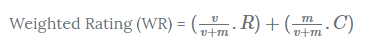

- v는 영화에 대한 투표 수입니다.
- m은 차트에 나열되는 데 필요한 최소 투표수입니다.
- R은 영화의 평균 등급입니다.
- C는 전체 보고서의 평균 투표수입니다.

In [8]:
C= df2['vote_average'].mean()
C

6.092171559442011

모든 영화의 평균 평점은 10점 만점에 약 6점입니다.

In [12]:
m= df2['vote_count'].quantile(0.9)
m

1838.4000000000015

백분위수 90을 컷오프로 사용합니다. 즉, 영화가 차트에 오르려면 목록에 있는 영화의 90% 이상을 득표해야 합니다.

In [13]:
q_movies = df2.copy().loc[df2['vote_count'] >= m]
q_movies.shape

(481, 23)

In [14]:
# Weighted Rating 함수 정의
def weighted_rating(x, m=m, C=C):
  v = x['vote_count']
  R = x['vote_average']
  return (v/(v+m) * R) + (m/(m+v) * C)

In [15]:
q_movies['score'] = q_movies.apply(weighted_rating, axis=1)

In [16]:
# 위에서 계산한 점수를 기준으로 영화 정렬
q_movies = q_movies.sort_values('score', ascending=False)

# top 10 영화 출력
q_movies[['title', 'vote_count', 'vote_average', 'score']].head(10)

,title,vote_count,vote_average,score
1881,The Shawshank Redemption,8205,8.5,8.059258
662,Fight Club,9413,8.3,7.939256
65,The Dark Knight,12002,8.2,7.920020
3232,Pulp Fiction,8428,8.3,7.904645
96,Inception,13752,8.1,7.863239
3337,The Godfather,5893,8.4,7.851236
95,Interstellar,10867,8.1,7.809479
809,Forrest Gump,7927,8.2,7.803188
329,The Lord of the Rings: The Return of the King,8064,8.1,7.727243
1990,The Empire Strikes Back,5879,8.2,7.697884


Text(0.5, 1.0, 'Popular Movies')

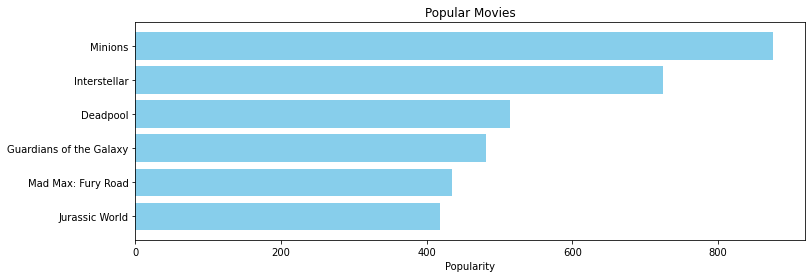

In [18]:
# 인기도 열을 기준으로 데이터세트를 정렬
# 질문 - 왜 굳이 위에 추천 스코어를 구하고 인기도 기준으로 시각화 정렬한건지?
pop = df2.sort_values('popularity', ascending=False)
import matplotlib.pyplot as plt
plt.figure(figsize=(12,4))

plt.barh(pop['title'].head(6),pop['popularity'].head(6), align='center',
        color='skyblue')
plt.gca().invert_yaxis()
plt.xlabel("Popularity")
plt.title("Popular Movies")

인구통계학적 추천은 모든 사용자에게 일반적인 추천만 제공할 뿐, 특정 사용자 취향에 맞춰주지는 않는다.